In [1]:
'''
In this program, EBF functions are used to solve Laplace problem with img results
'''
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from funcs import *
tf.random.set_seed(42)
tf.keras.backend.set_floatx('float64')

In [2]:
# Define exponential functions
def function(inputs, weights):
    [x, y] = inputs
    [alfa, beta, coef] = weights
    u = (tf.reduce_sum(tf.exp(x*alfa + y*beta) * coef, axis=1))[:, None]
    return u
def functionx(inputs, weights):
    [x, y] = inputs
    [alfa, beta, coef] = weights
    ux = (tf.reduce_sum(tf.exp(x*alfa + y*beta) * coef * alfa, axis=1))[:, None]
    return ux
def functiony(inputs, weights):
    [x, y] = inputs
    [alfa, beta, coef] = weights
    uy = (tf.reduce_sum(tf.exp(x*alfa + y*beta) * coef * beta, axis=1))[:, None]
    return uy
def functionxx(inputs, weights):
    [x, y] = inputs
    [alfa, beta, coef] = weights
    uxx = (tf.reduce_sum(tf.exp(x*alfa + y*beta) * coef * alfa**2, axis=1))[:, None]
    return uxx
def functionyy(inputs, weights):
    [x, y] = inputs
    [alfa, beta, coef] = weights
    uyy = (tf.reduce_sum(tf.exp(x*alfa + y*beta) * coef * beta**2, axis=1))[:, None]
    return uyy
def functionxy(inputs, weights):
    [x, y] = inputs
    [alfa, beta, coef] = weights
    uxy = (tf.reduce_sum(tf.exp(x*alfa + y*beta) * coef * alfa * beta, axis=1))[:, None]
    return uxy

In [3]:
# --------------- Prepare Data ---------------
Emodule = 5.0
nu = 0.2
x_start=-1.0
x_end=1.0
y_start=-1.0
y_end=1.0
# --------------- Define inputs ---------------
numsample = 2500
input_data_domain = np.hstack([np.random.uniform(x_start, x_end, numsample)[:, None], np.random.uniform(y_start, y_end, numsample)[:, None]])
input_data_domain_x = input_data_domain[:, [0]]
input_data_domain_y = input_data_domain[:, [1]]

numsample_bc_left = int(numsample)
input_data_bc_left = np.hstack([np.ones(numsample_bc_left)[:, None]*x_start, np.random.uniform(y_start, y_end, numsample_bc_left)[:, None]])
input_data_bc_left_x = input_data_bc_left[:, [0]]
input_data_bc_left_y = input_data_bc_left[:, [1]]

numsample_bc_right = int(numsample)
input_data_bc_right = np.hstack([np.ones(numsample_bc_right)[:, None]*x_end, np.random.uniform(y_start, y_end, numsample_bc_right)[:, None]])
input_data_bc_right_x = input_data_bc_right[:, [0]]
input_data_bc_right_y = input_data_bc_right[:, [1]]

numsample_bc_top = int(numsample)
input_data_bc_top = np.hstack([np.random.uniform(x_start, x_end, numsample_bc_top)[:, None], np.ones(numsample_bc_top)[:, None]*y_end])
input_data_bc_top_x = input_data_bc_top[:, [0]]
input_data_bc_top_y = input_data_bc_top[:, [1]]

numsample_bc_bot = int(numsample)
input_data_bc_bot = np.hstack([np.random.uniform(x_start, x_end, numsample_bc_bot)[:, None], np.ones(numsample_bc_bot)[:, None]*y_start])
input_data_bc_bot_x = input_data_bc_bot[:, [0]]
input_data_bc_bot_y = input_data_bc_bot[:, [1]]

target_data = np.zeros(numsample)
# --------------- Define functional model ---------------
dtype = tf.complex128
# inputs = tf.keras.Input(shape=(2,), dtype=dtype, name='domain_inputs')
inputs_x = tf.keras.Input(shape=(1,), dtype=dtype, name='domain_inputs_x')
inputs_y = tf.keras.Input(shape=(1,), dtype=dtype, name='domain_inputs_y')

# inputs_bxl = tf.keras.Input(shape=(2,), dtype=dtype, name='boundary_xl_inputs')
inputs_x_bxl = tf.keras.Input(shape=(1,), dtype=dtype, name='boundary_xl_inputs_x')
inputs_y_bxl = tf.keras.Input(shape=(1,), dtype=dtype, name='boundary_xl_inputs_y')

# inputs_bxr = tf.keras.Input(shape=(2,), dtype=dtype, name='boundary_xr_inputs')
inputs_x_bxr = tf.keras.Input(shape=(1,), dtype=dtype, name='boundary_xr_inputs_x')
inputs_y_bxr = tf.keras.Input(shape=(1,), dtype=dtype, name='boundary_xr_inputs_y')

# inputs_byb = tf.keras.Input(shape=(2,), dtype=dtype, name='boundary_yb_inputs')
inputs_x_byb = tf.keras.Input(shape=(1,), dtype=dtype, name='boundary_yb_inputs_x')
inputs_y_byb = tf.keras.Input(shape=(1,), dtype=dtype, name='boundary_yb_inputs_y')

# inputs_byt = tf.keras.Input(shape=(2,), dtype=dtype, name='boundary_yt_inputs')
inputs_x_byt = tf.keras.Input(shape=(1,), dtype=dtype, name='boundary_yt_inputs_x')
inputs_y_byt = tf.keras.Input(shape=(1,), dtype=dtype, name='boundary_yt_inputs_y')

inputs = [inputs_x, inputs_y]
inputs_bxl = [inputs_x_bxl, inputs_y_bxl]
inputs_byb = [inputs_x_byb, inputs_y_byb]
inputs_bxr = [inputs_x_bxr, inputs_y_bxr]
inputs_byt = [inputs_x_byt, inputs_y_byt]
n_coef = 100 # number of EBFs

# --------------- Define Variables ---------------
var_list = {'u':{'powers':['alfau', 'betau'], 'coefs':['coefu']}}
var_name_list = list(var_list.keys())
powers_list = []
coefs_list = []
for var in var_name_list:
    powers_list = powers_list + var_list[var]['powers']
    coefs_list = coefs_list + var_list[var]['coefs']
powers_list_unique = []
[powers_list_unique.append(i) for i in powers_list if i not in powers_list_unique]
coefs_list_unique = []
[coefs_list_unique.append(i) for i in coefs_list if i not in coefs_list_unique]

# --------------- Create Variable Layers ---------------
for i, power in enumerate(powers_list_unique):
    code_lines = [
        f'{power}_real_layer = real_variable(initial_value=None, nvariable=n_coef, name=\'a_{power}\', seed={42+i}, kernel_min_max=[-.1, .1])',
        f'{power}_img_layer = real_variable(initial_value=None, nvariable=n_coef, name=\'b_{power}\', seed={42+i+10}, kernel_min_max=[-.1, .1])',
        f'{power}_layer = complex_variable(name=\'{power}_layer\')',
        f'{power}_real = {power}_real_layer([inputs])',
        f'{power}_img = {power}_img_layer([inputs])',
        f'{power} = {power}_layer([{power}_real, {power}_img])']
    for code_line in code_lines:
        exec(code_line)

for i, coef in enumerate(coefs_list_unique):
    code_lines = [
        f'{coef}_layer = real_variable(initial_value=None, nvariable=n_coef, name=\'{coef}\', seed={42*2+i}, complex=\'complex\', kernel_min_max=[-0.1, 0.1])',
        f'{coef} = {coef}_layer([inputs])']
    for code_line in code_lines:
        exec(code_line)

In [4]:
for var in var_name_list:
    code_lines = [f'{var}_layer = tf.keras.layers.Lambda(lambda x: function(x[0], x[1]), name=\'{var}_layer\')',
                  f'{var}x_layer = tf.keras.layers.Lambda(lambda x: functionx(x[0], x[1]), name=\'{var}x_layer\')',
                  f'{var}y_layer = tf.keras.layers.Lambda(lambda x: functiony(x[0], x[1]), name=\'{var}y_layer\')',
                  f'{var}xx_layer = tf.keras.layers.Lambda(lambda x: functionxx(x[0], x[1]), name=\'{var}xx_layer\')',
                  f'{var}yy_layer = tf.keras.layers.Lambda(lambda x: functionyy(x[0], x[1]), name=\'{var}yy_layer\')',
                  f'{var}xy_layer = tf.keras.layers.Lambda(lambda x: functionxy(x[0], x[1]), name=\'{var}xy_layer\')']
    for code_line in code_lines:
        exec(code_line)


# --------------- Declare Domain Functions ---------------
for var in var_name_list:
    coefs_inputs = ', '.join(var_list[var]['powers'] + var_list[var]['coefs'])
    code_lines = [f'{var}_appx = {var}_layer([inputs, [{coefs_inputs}]])',
                  f'{var}x_appx = {var}x_layer([inputs, [{coefs_inputs}]])',
                  f'{var}y_appx = {var}y_layer([inputs, [{coefs_inputs}]])',
                  f'{var}xx_appx = {var}xx_layer([inputs, [{coefs_inputs}]])',
                  f'{var}yy_appx = {var}yy_layer([inputs, [{coefs_inputs}]])',
                  f'{var}xy_appx = {var}xy_layer([inputs, [{coefs_inputs}]])']
    for code_line in code_lines:
        exec(code_line)


# --------------- Declare Boundary Functions ---------------
for var in var_name_list:
    for boundary_input in ['bxl', 'bxr', 'byb', 'byt']:
        inputs_str = 'inputs_' + boundary_input
        coefs_inputs = ', '.join(var_list[var]['powers'] + var_list[var]['coefs'])
        code_lines = [f'{var}_appx_{boundary_input} = {var}_layer([{inputs_str}, [{coefs_inputs}]])',
                      f'{var}x_appx_{boundary_input} = {var}x_layer([{inputs_str}, [{coefs_inputs}]])',
                      f'{var}y_appx_{boundary_input} = {var}y_layer([{inputs_str}, [{coefs_inputs}]])',
                      f'{var}xx_appx_{boundary_input} = {var}xx_layer([{inputs_str}, [{coefs_inputs}]])',
                      f'{var}yy_appx_{boundary_input} = {var}yy_layer([{inputs_str}, [{coefs_inputs}]])',
                      f'{var}xy_appx_{boundary_input} = {var}xy_layer([{inputs_str}, [{coefs_inputs}]])']
        for code_line in code_lines:
            exec(code_line)

# Exx = ux_appx
# Eyy = vy_appx
# Exy = tf.keras.layers.Lambda(lambda x: (x[0] + x[1])*0.5, name='Exy')([uy_appx, vx_appx])

# Laplace equation

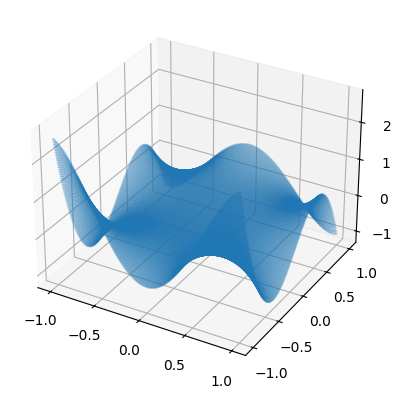

In [5]:
# Draw exact real solution
def U_exact(x, y):
    x_float = tf.math.real(x)
    y_float = tf.math.real(y)
    U = 0.5*tf.complex(y_float, x_float)**5 - 0.2*tf.complex(y_float, x_float)**4 + 0.3*tf.complex(y_float, x_float)**2 + 0.2*tf.complex(y_float, x_float)**1
    return U

X, Y= np.meshgrid(np.linspace(-1, 1, 300), np.linspace(-1, 1, 300))
X, Y= [X.flatten()[:, None], Y.flatten()[:, None]]
fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
ax.scatter(X, Y, tf.math.real(U_exact(X, Y)), s=0.02)

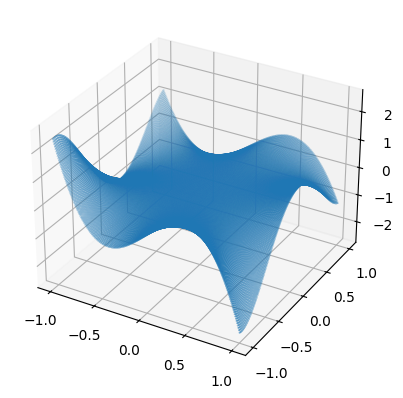

In [8]:
# Draw exact imaginary solution
fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
ax.scatter(X, Y, tf.math.imag(U_exact(X, Y)), s=0.02)

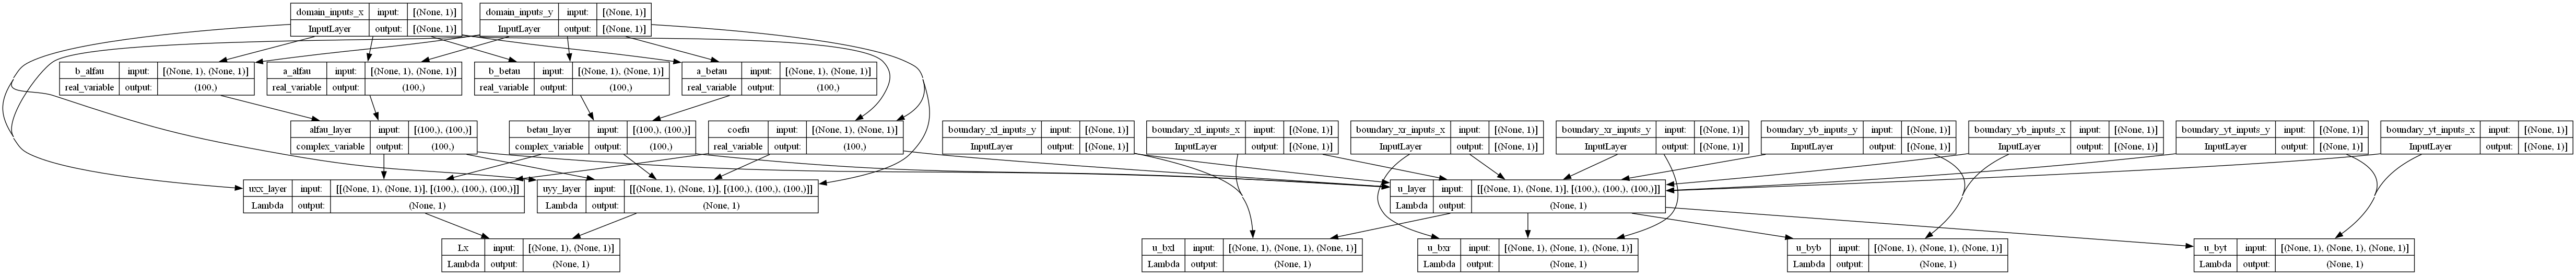

In [6]:
cons = Emodule*(1-nu)/(1-2*nu)/(1+nu) # Plain-Strain
C11 = cons
C22 = cons
C12 = cons*nu/(1-nu)
C33 = cons*(1-2*nu)/(1-nu)

def model():
    Lx = tf.keras.layers.Lambda(lambda x: x[0] + x[1], name='Lx')([uxx_appx, uyy_appx])
    
    outputs_bl = tf.keras.layers.Lambda(lambda x: x[0] - U_exact(x[1], x[2]), name='u_bxl')([u_appx_bxl, inputs_x_bxl, inputs_y_bxl])
    outputs_br = tf.keras.layers.Lambda(lambda x: x[0] - U_exact(x[1], x[2]), name='u_bxr')([u_appx_bxr, inputs_x_bxr, inputs_y_bxr])
    outputs_bb = tf.keras.layers.Lambda(lambda x: x[0] - U_exact(x[1], x[2]), name='u_byb')([u_appx_byb, inputs_x_byb, inputs_y_byb])
    outputs_bt = tf.keras.layers.Lambda(lambda x: x[0] - U_exact(x[1], x[2]), name='u_byt')([u_appx_byt, inputs_x_byt, inputs_y_byt])
    
    outputs_list = [Lx,
                    outputs_bl, outputs_br, outputs_bb, outputs_bt]
    # --------------- Model Creation ---------------
    model = tf.keras.Model(inputs=[inputs, inputs_bxl, inputs_bxr, inputs_byb, inputs_byt], outputs=outputs_list)
    return model
# --------------- Draw Model ---------------
from tensorflow.keras.utils import plot_model
display(plot_model(model(), show_shapes=True))

In [7]:
# Using MSE loss function with real and img parts
def custom_mse_realandimg(y_true, y_pred):
    loss = tf.keras.backend.mean(tf.keras.backend.square(tf.math.real(y_pred) - tf.math.real(y_true))) + tf.keras.backend.mean(tf.keras.backend.square(tf.math.imag(y_pred) - tf.math.imag(y_true)))
    return loss

Epoch 1 / 100, Loss: 6.189659822689108, Accuracy: ['Lx_mse: 0.01282188354367928', 'u_bxl_mse: 0.6596466946130568', 'u_bxr_mse: 0.6954144787614402', 'u_byb_mse: 1.4163904754804209', 'u_byt_mse: 0.4456864101442808'], lr: 0.009999999776482582, elapced time:1906 ms
Epoch 2 / 100, Loss: 5.9025119612764305, Accuracy: ['Lx_mse: 0.03386167855317298', 'u_bxl_mse: 0.6171012154994805', 'u_bxr_mse: 0.6316742903732758', 'u_byb_mse: 1.4062541119895944', 'u_byt_mse: 0.4120974054805445'], lr: 0.00911162793636322, elapced time:384 ms
Epoch 3 / 100, Loss: 5.64097903377477, Accuracy: ['Lx_mse: 0.029275458161540837', 'u_bxl_mse: 0.5795714511328941', 'u_bxr_mse: 0.5380173396074537', 'u_byb_mse: 1.3368808280822901', 'u_byt_mse: 0.43950542621676886'], lr: 0.0083021754398942, elapced time:396 ms
Epoch 4 / 100, Loss: 2.033917321046251, Accuracy: ['Lx_mse: 0.020196125180174888', 'u_bxl_mse: 0.1996854552003688', 'u_bxr_mse: 0.12707574211370332', 'u_byb_mse: 0.2870231398748943', 'u_byt_mse: 0.4125863198169765'], 

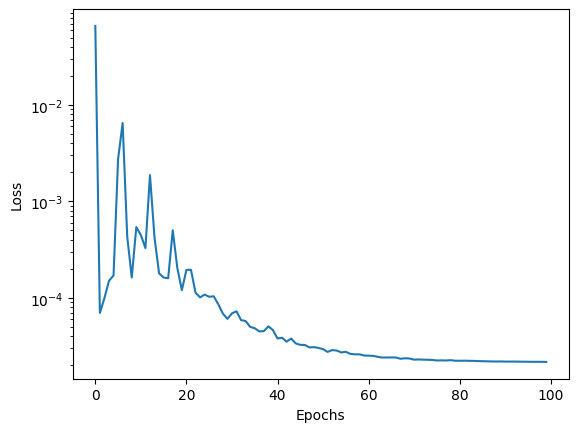

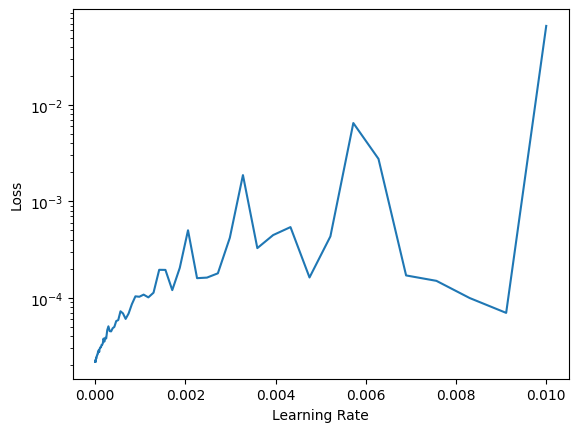

In [8]:
loss_list = []
for _ in range(10):
    # --------------- Configure Training Parameters ---------------
    Epochs = 100
    initial_lr = 0.01
    final_lr = 0.000001
    # --------------- Train the Model ---------------
    input_data = [[input_data_domain_x, input_data_domain_y],
                  [input_data_bc_left_x, input_data_bc_left_y],
                  [input_data_bc_right_x, input_data_bc_right_y],
                  [input_data_bc_bot_x, input_data_bc_bot_y],
                  [input_data_bc_top_x, input_data_bc_top_y]]
    optimizer = tf.keras.optimizers.Adam(
        learning_rate = initial_lr)
    xnodes = 100
    ynodes = 100
    xs = np.arange(xnodes)[:, None]/xnodes
    ys = np.arange(ynodes)[:, None]/ynodes
    X, Y = np.meshgrid(xs, ys)
    train_data=[X.ravel(), Y.ravel()]
    loss_function = 'mse'
    modeli = model()
    modeli.compile(optimizer=optimizer, loss=custom_mse_realandimg, metrics=['mse'])
    mhist = modeli.fit(input_data,
                      len(modeli.outputs)*[target_data.astype(dtype=np.complex128)],
                      batch_size=10,
                      epochs=Epochs,
                      verbose=0,
                      callbacks=[StopTraining(10**-8),
                                 lr_scheduler(Epochs=Epochs, initial_lr=initial_lr, final_lr=final_lr), PrintFreq(print_freq=1),
                                 ])
    _loss = mhist.history['loss'].copy()
    loss_list += [_loss]
loss_fig(mhist)

In [93]:
loss_list_20 = loss_list

In [ ]:
loss_list_50 = loss_list

In [9]:
loss_list_100 = loss_list

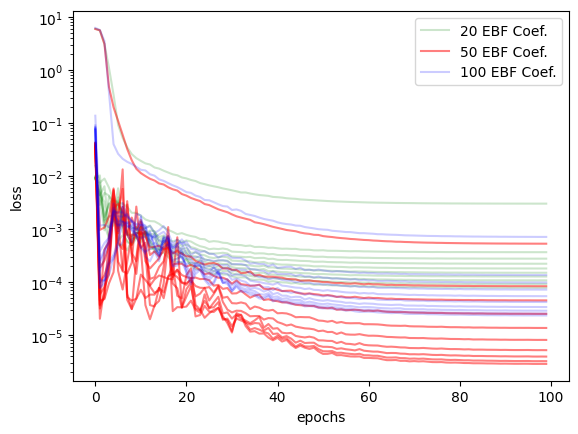

In [96]:
plt20 = plt.semilogy(np.array(loss_list_20).T, c='g', alpha=0.2)
plt50 = plt.semilogy(np.array(loss_list_50).T, c='r', alpha=0.5)
plt100 = plt.semilogy(np.array(loss_list_100).T, c='b', alpha=0.2)
plt.legend(handles=[plt20[0], plt50[0], plt100[0]],
           labels=['20 EBF Coef.', '50 EBF Coef.', '100 EBF Coef.'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.savefig('Compare Laplace coefficients.svg')

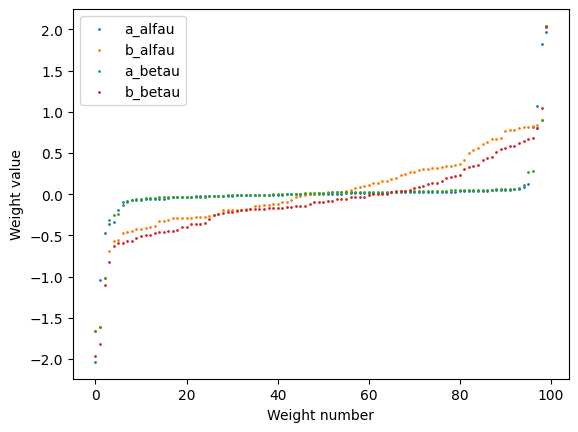

In [10]:
_weights = modeli.get_layer('a_alfau').weights[0]
plt_a_alfau = plt.scatter(np.arange(_weights.shape[0]), np.sort(_weights), s=1)
plt.xlabel('Weight number')
plt.ylabel('Weight value')
_weights = modeli.get_layer('b_alfau').weights[0]
plt_b_alfau = plt.scatter(np.arange(_weights.shape[0]), np.sort(_weights), s=1)
plt.xlabel('Weight number')
plt.ylabel('Weight value')
_weights = modeli.get_layer('a_betau').weights[0]
plt_a_betau = plt.scatter(np.arange(_weights.shape[0]), np.sort(_weights), s=1)
plt.xlabel('Weight number')
plt.ylabel('Weight value')
_weights = modeli.get_layer('b_betau').weights[0]
plt_b_betau = plt.scatter(np.arange(_weights.shape[0]), np.sort(_weights), s=1)
plt.xlabel('Weight number')
plt.ylabel('Weight value')
plt.savefig('weights in Laplace')
plt.legend(labels=['a_alfau', 'b_alfau', 'a_betau', 'b_betau'])

Text(0.5, 1.0, 'U_imag Exact')

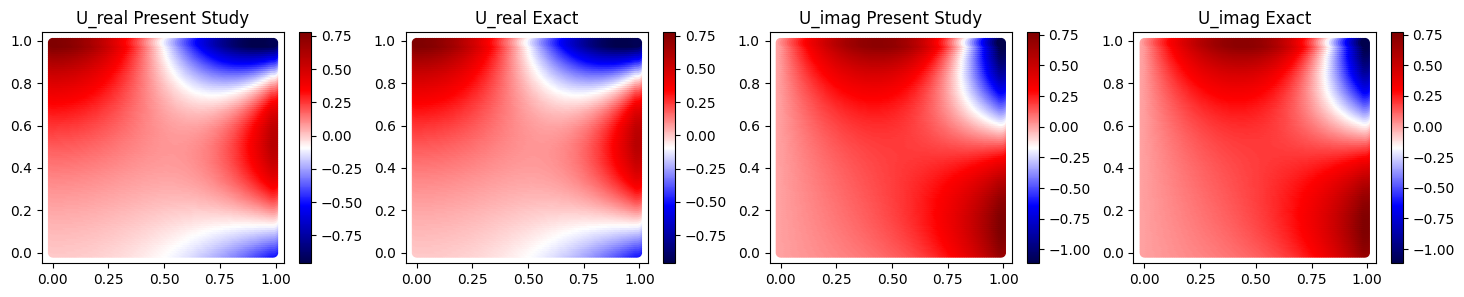

In [11]:
# --------------- Print u_layer Outputs and Plot ---------------
xnodes = 100
ynodes = 100
xs = np.arange(xnodes)[:, None]/xnodes
ys = np.arange(ynodes)[:, None]/ynodes
X, Y = np.meshgrid(xs, ys)
train_data=[X.ravel(), Y.ravel()]
del(X, Y)
u_pred = np.squeeze(tf.keras.backend.function(modeli.input[0], [modeli.get_layer('u_layer').output])([train_data]))
u_exact = U_exact(train_data[0], train_data[1])

fig,ax = plt.subplots(1,4,figsize=(18,3))
ax0 = ax[0].scatter(train_data[0], train_data[1], c=u_pred.real.flatten(), cmap='seismic')
ax1 = ax[1].scatter(train_data[0], train_data[1], c=tf.math.real(u_exact), cmap='seismic')
ax2 = ax[2].scatter(train_data[0], train_data[1], c=u_pred.imag.flatten(), cmap='seismic')
ax3 = ax[3].scatter(train_data[0], train_data[1], c=tf.math.imag(u_exact), cmap='seismic')
plt.colorbar(ax0)
plt.colorbar(ax1)
plt.colorbar(ax2)
plt.colorbar(ax3)
ax[0].set_title("U_real Present Study")
ax[1].set_title("U_real Exact")
ax[2].set_title("U_imag Present Study")
ax[3].set_title("U_imag Exact")

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8), subplot_kw={'projection': '3d'})
X, Y= np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
X, Y= [X.flatten()[:, None], Y.flatten()[:, None]]
u_pred = np.squeeze(tf.keras.backend.function(modeli.input[0], [modeli.get_layer('u_layer').output])([X,Y]))

axs[0, 0].scatter(X, Y, u_pred.real, s=0.1)
axs[0, 0].set_title('U_real Present Study')

axs[0, 1].scatter(X, Y, tf.math.real(U_exact(X, Y)), s=0.1)
axs[0, 1].set_title('U_real Exact')

axs[1, 0].scatter(X, Y, u_pred.imag, s=0.1)
axs[1, 0].set_title('U_imag Present Study')

axs[1, 1].scatter(X, Y, tf.math.imag(U_exact(X, Y)), s=0.1)
axs[1, 1].set_title('U_imag Exact')
plt.show()